# Introduction

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for 
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation. 

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner! 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

# define the train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



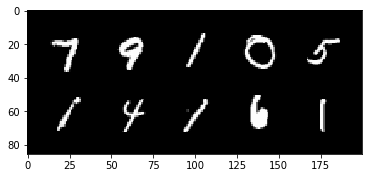

In [5]:
visualize_images(train_dataloader)

In [10]:
next(iter(train_dataloader))[0][0].shape

torch.Size([1, 28, 28])

In [11]:
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),            # output shape (16,28, 28)                  
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),  # output shape (16,14, 14)
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),  # output shape (32,14, 14)
            nn.ReLU(),                      
            nn.MaxPool2d(2),           # output shape (32,7, 7)
        )
              
        # fully connected layer, output 10 classes   
        self.out = nn.Linear(32*7*7, 10)    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   
        

In [13]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer.
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
fit(cnn, train_dataloader, optimizer, 10, DEVICE)

# predict
predict(cnn, test_dataloader, DEVICE)

Epoch 0: Loss=1.7253812763650538
Epoch 1: Loss=0.46232873554957116
Epoch 2: Loss=0.2678286882780366
Epoch 3: Loss=0.20449888933513125
Epoch 4: Loss=0.1726266221474793
Epoch 5: Loss=0.15026592829469906
Epoch 6: Loss=0.1337083263669984
Epoch 7: Loss=0.12237438597416474
Epoch 8: Loss=0.11120280951766645
Epoch 9: Loss=0.10386936038227404
Test set: Avg. loss: 0.0972, Accuracy: 9704/10000 (97%)


(0.09721641578674316, tensor(97.0400, device='cuda:0'))

## CIFAR10

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


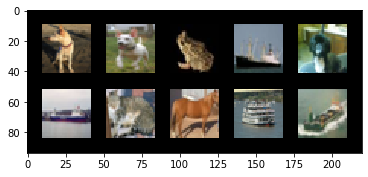

In [14]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

# define the train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

visualize_images(train_dataloader)

In [16]:
next(iter(train_dataloader))[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer. 
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)


# train the CNN
fit(cnn, train_dataloader, optimizer, 10, DEVICE)

# predict
predict(cnn, test_dataloader, DEVICE)

The above failed! Why? Make modifications to the model and perform the same training loop.

In [17]:
class CifarCNN(nn.Module): 
    def __init__(self):
        super().__init__()
        # Define the same model as before. What must be changed to make the model 
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),            # output shape (16,32, 32)                  
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),  # output shape (16,16, 16)
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),  # output shape (32,16, 16)
            nn.ReLU(),                      
            nn.MaxPool2d(2),           # output shape (32,8, 8)
        )
              
        # fully connected layer, output 10 classes   
        self.out = nn.Linear(32*8*8, 10)    
        
    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   

cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer.
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)

# train the CNN
fit(cnn_cifar, train_dataloader, optimizer, 10, DEVICE)

# predict
predict(cnn_cifar, test_dataloader, DEVICE)

Epoch 0: Loss=2.2252733512800567
Epoch 1: Loss=2.1102092120112204
Epoch 2: Loss=1.975439531462533
Epoch 3: Loss=1.8755972628690758
Epoch 4: Loss=1.7536532027380807
Epoch 5: Loss=1.6971054588045393
Epoch 6: Loss=1.6290155162616653
Epoch 7: Loss=1.5798253550821422
Epoch 8: Loss=1.552956907116637
Epoch 9: Loss=1.517120675164826
Test set: Avg. loss: 1.4562, Accuracy: 4853/10000 (49%)


(1.456188134765625, tensor(48.5300, device='cuda:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in. 

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [21]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

print(train_dataset)

# Split the training set into training + validation. 
# How many samples does the training set have?
print(f"The training set has {len(train_dataset)} samples.")

# Split the dataset into ?????-10k samples for training-validation.
validation_size = 10000
valid_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [validation_size, len(train_dataset) - validation_size])

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()
The training set has 60000 samples.


In [22]:
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

Modify the fit function to also use a validation set

In [23]:
from typing import Optional

def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    
        # keep track of the losses in order to visualize them later
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        
        valid_loss, accuracy = predict(model, valid_dataloader, device)
        valid_losses.append(valid_loss)
        valid_accs.append(accuracy)
        
        print(f"Epoch {epoch}: Loss={running_loss}")
        print(f"Epoch {epoch}: Valid Loss={valid_loss}, Valid Accuracy={accuracy}")
        train_losses.append(running_loss)

    return train_losses, valid_losses, valid_accs

In [24]:
cnn = CNN().to(DEVICE)

# define the optimizer.
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

train_losses, valid_losses, valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.8805, Accuracy: 7703/10000 (77%)
Epoch 0: Loss=1.665816836211146
Epoch 0: Valid Loss=0.8804550659179687, Valid Accuracy=77.02999877929688
Test set: Avg. loss: 0.4117, Accuracy: 8610/10000 (86%)
Epoch 1: Loss=0.5681400323400692
Epoch 1: Valid Loss=0.41165140075683593, Valid Accuracy=86.0999984741211
Test set: Avg. loss: 0.2618, Accuracy: 9213/10000 (92%)
Epoch 2: Loss=0.3269848458620967
Epoch 2: Valid Loss=0.2618261016845703, Valid Accuracy=92.12999725341797
Test set: Avg. loss: 0.1985, Accuracy: 9415/10000 (94%)
Epoch 3: Loss=0.2370431991864224
Epoch 3: Valid Loss=0.19847675018310548, Valid Accuracy=94.14999389648438
Test set: Avg. loss: 0.1701, Accuracy: 9507/10000 (95%)
Epoch 4: Loss=0.19503985983984812
Epoch 4: Valid Loss=0.17010132293701172, Valid Accuracy=95.06999969482422
Test set: Avg. loss: 0.1493, Accuracy: 9568/10000 (96%)
Epoch 5: Loss=0.16593181509144453
Epoch 5: Valid Loss=0.14929696960449218, Valid Accuracy=95.68000030517578
Test set: Avg. loss: 0.1

(0.10240766944885255, tensor(96.9400, device='cuda:0'))

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

Test set: Avg. loss: 0.1036, Accuracy: 9703/10000 (97%)
Epoch 0: Loss=0.10630042227555295
Epoch 0: Valid Loss=0.10360513992309571, Valid Accuracy=97.02999877929688
Test set: Avg. loss: 0.1025, Accuracy: 9707/10000 (97%)
Epoch 1: Loss=0.10385295642273766
Epoch 1: Valid Loss=0.10245484313964844, Valid Accuracy=97.06999969482422
Test set: Avg. loss: 0.1021, Accuracy: 9714/10000 (97%)
Epoch 2: Loss=0.10318711749753173
Epoch 2: Valid Loss=0.10208385925292969, Valid Accuracy=97.13999938964844
Test set: Avg. loss: 0.1019, Accuracy: 9714/10000 (97%)
Epoch 3: Loss=0.10294524169698054
Epoch 3: Valid Loss=0.10191904678344726, Valid Accuracy=97.13999938964844
Test set: Avg. loss: 0.1018, Accuracy: 9715/10000 (97%)
Epoch 4: Loss=0.10269266944758747
Epoch 4: Valid Loss=0.10182594604492187, Valid Accuracy=97.14999389648438
Test set: Avg. loss: 0.1018, Accuracy: 9714/10000 (97%)
Epoch 5: Loss=0.10262890525010167
Epoch 5: Valid Loss=0.10175504989624023, Valid Accuracy=97.13999938964844
Test set: Avg. l

Text(0, 0.5, 'Train loss')

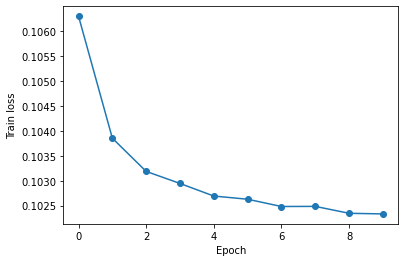

In [25]:
# YOUR CODE GOES HERE
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

train_losses, valid_losses, valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla \mathcal{L}\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla \mathcal{L}\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations 
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



Test set: Avg. loss: 2.2623, Accuracy: 4099/10000 (41%)
Epoch 0: Loss=2.285246634969906
Epoch 0: Valid Loss=2.2622634155273436, Valid Accuracy=40.98999786376953
Test set: Avg. loss: 2.1928, Accuracy: 5515/10000 (55%)
Epoch 1: Loss=2.2328815411548226
Epoch 1: Valid Loss=2.1928456665039064, Valid Accuracy=55.14999771118164
Test set: Avg. loss: 2.0442, Accuracy: 6495/10000 (65%)
Epoch 2: Loss=2.132718957200342
Epoch 2: Valid Loss=2.0441571655273436, Valid Accuracy=64.94999694824219
Test set: Avg. loss: 1.6787, Accuracy: 6999/10000 (70%)
Epoch 3: Loss=1.8952917079536282
Epoch 3: Valid Loss=1.6787048217773437, Valid Accuracy=69.98999786376953
Test set: Avg. loss: 1.0801, Accuracy: 7595/10000 (76%)
Epoch 4: Loss=1.3927788685779183
Epoch 4: Valid Loss=1.080107586669922, Valid Accuracy=75.94999694824219
Test set: Avg. loss: 0.7230, Accuracy: 8115/10000 (81%)
Epoch 5: Loss=0.8876432788615324
Epoch 5: Valid Loss=0.72301572265625, Valid Accuracy=81.1500015258789
Test set: Avg. loss: 0.5737, Accur

Text(0, 0.5, 'Train loss')

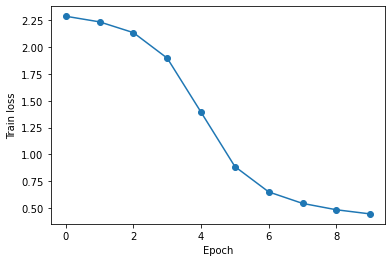

In [26]:
cnn = CNN().to(DEVICE)

# YOUR CODE GOES HERE
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perfrom a grid search; define a list of choices for each hyperparameter and search over all combinations.

In [ ]:
# Perform a grid search over 2 values of learning rate and 2 values of Batch size.

from itertools import product

LR_GRID = [0.01, 0.1]
BS_GRID = [256, 512]

# YOUR CODE GOES HERE


In [ ]:
# Evaluate the performance on the test set with the best model!
predict(model=..., test_dataloader=test_dataloader, device=DEVICE)


## CIFAR10

Modify the models, the epochs, the optimizers, the grid search etc and repeat the process on the more challenging dataset of CIFAR10.